# Transformation to C Code (Medium)

## Imports

In [2]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np

from library.fvm.solver import Settings
from library.model.models.shallow_water import ShallowWaterEquations

import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
from library.misc.misc import Zstruct
import library.transformation.to_c as trafo

2025-08-25 09:05:33.354 | WARNING  | library.fvm.solver:<module>:28 - No module named 'precice'


## Model definition

In [3]:
bcs = BC.BoundaryConditions(
    [
        BC.Wall(physical_tag="top"),
        BC.Wall(physical_tag="bottom"),
        BC.Wall(physical_tag="left"),
        BC.Wall(physical_tag="right"),
    ]
)

def custom_ic(x):
    Q = np.zeros(3, dtype=float)
    Q[0] = np.where(x[0] < 5., 0.005, 0.001)
    return Q

ic = IC.UserFunction(custom_ic)

model = ShallowWaterEquations(
    dimension=2,
    boundary_conditions=bcs,
    initial_conditions=ic,
)



In [5]:
import sympy as sp

In [144]:
import sympy as sp
from sympy.printing.cxx import CXX11CodePrinter
import re


class AmrexPrinter(CXX11CodePrinter):
    """
    After the normal C++ printer has done its job, replace every
    'std::foo(' with 'amrex::Math::foo('  – except if foo is listed
    in 'custom_map'.  No other overrides are necessary.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.map_Q = {k: f"Q({i})" for i, k in enumerate(model.variables.values())}
        self.map_Qaux = {k: f"Qaux({i})" for i, k in enumerate(model.aux_variables.values())}
        self.map_param = {k: str(float(model.parameter_values[i])) for i, k in enumerate(model.parameters.values())}
        self.custom_map = {}
        # names that should *keep* their std:: prefix
        self._keep_std = set(self.custom_map or ())

        # pre-compile regex  std::something(
        self._std_regex = re.compile(r'std::([A-Za-z_]\w*)')
        
    def _print_Symbol(self, s):
        for map in [self.map_Q, self.map_Qaux, self.map_param]:
            if s in map:
                return map[s]
        return super()._print_Symbol(s)

    # the only method we override
    def doprint(self, expr, **settings):
        code = super().doprint(expr, **settings)

        # callback that the regex will call for every match
        def _repl(match):
            fname = match.group(1)
            if fname in self._keep_std:
                return f'std::{fname}'
            else:
                return f'amrex::Math::{fname}'

        # apply the replacement to the whole code string
        return self._std_regex.sub(_repl, code) 

    def convert_expression_body(self, expr, target='res'):

        tmp_sym   = sp.numbered_symbols('t') 
        temps, simplified = sp.cse(expr, symbols=tmp_sym)  
        lines = []
        for lhs, rhs in temps:
            lines.append(f"amrex::Real {self.doprint(lhs)} = {self.doprint(rhs)};")

        for i in range(expr.rows):
            for j in range(expr.cols):
                lines.append(f"{target}({i},{j}) = {self.doprint(simplified[0][i, j])};")

        body = '\n            '.join(lines)
        return body
    
    def createSmallMatrix(self, rows, cols):
        return f"amrex::SmallMatrix<amrex::Real,{rows},{cols}>"
    
    def create_file_header(self, n_dof, n_dim):
        header = f"""\ 
        #pragma once
        #include <AMReX_Array4.H>
        #include <AMReX_Vector.H>
        """
        return header
    
    def create_function(self, name, expr, n_dof_q, n_dof_qaux):
        res_shape = expr.shape
        header = f"""\
        AMREX_GPU_HOST_DEVICE
        AMREX_FORCE_INLINE
        {self.createSmallMatrix(*res_shape)}
        {name} ( {self.createSmallMatrix(n_dof_q, 1)} const& Q,
            {self.createSmallMatrix(n_dof_qaux, 1)} const& Qaux) noexcept
        """
        body = self.convert_expression_body(expr, target='res')
        full = f"""{header}
        {{
            {body}
            return res;
        }}
        """
        return full
    
    



In [ ]:
sp.Matrix.hstack(*model.quasilinear_matrix())

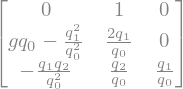

In [148]:
model.quasilinear_matrix()[0]

In [145]:
printer = AmrexPrinter()
n_dof = model.n_variables
n_dof_qaux = model.n_aux_variables
dim =  model.dimension
# print(printer.create_function('source', model.source(), n_dof, n_dof_qaux, (n_dof, 1)))
# print(printer.create_function('flux', sp.Matrix.hstack(*model.flux()), n_dof, n_dof_qaux, (n_dof, dim)))
print(printer.create_function('quasilinear_matrix', sp.Matrix.hstack(*model.quasilinear_matrix()), n_dof, n_dof_qaux))

        AMREX_GPU_HOST_DEVICE
        AMREX_FORCE_INLINE
        amrex::SmallMatrix<amrex::Real,3,6>
        quasilinear_matrix ( amrex::SmallMatrix<amrex::Real,3,1> const& Q,
            amrex::SmallMatrix<amrex::Real,2,1> const& Qaux) noexcept
        
        {
            amrex::Real t0 = 9.81*Q(0);
            amrex::Real t1 = amrex::Math::pow(Q(0), -2);
            amrex::Real t2 = 1.0/Q(0);
            amrex::Real t3 = Q(1)*t2;
            amrex::Real t4 = -Q(1)*Q(2)*t1;
            amrex::Real t5 = Q(2)*t2;
            res(0,0) = 0;
            res(0,1) = 1;
            res(0,2) = 0;
            res(0,3) = 0;
            res(0,4) = 0;
            res(0,5) = 1;
            res(1,0) = -amrex::Math::pow(Q(1), 2)*t1 + t0;
            res(1,1) = 2*t3;
            res(1,2) = 0;
            res(1,3) = t4;
            res(1,4) = t5;
            res(1,5) = t3;
            res(2,0) = t4;
            res(2,1) = t5;
            res(2,2) = t3;
            res(2,3) = -amrex::Math::pow(Q(2), 

## Code transformation

In [3]:
settings = Settings(name="ShallowWater", output=Zstruct(directory="outputs/trafo", filename="swe.h5"))

trafo.to_c(model, settings)

2025-08-25 08:11:19.951 | WARNING  | library.misc.misc:__init__:146 - No 'clean_directory' attribute found in output Zstruct. Default: False


In [5]:
print(os.path.join(main_dir,settings.output.directory))

/home/ingo/Git/Zoomy/outputs/trafo


## Check the output

In [4]:
main_dir = os.getenv("ZOOMY_DIR")
path = os.path.join(main_dir, os.path.join(settings.output.directory, '.c_interface/Model/model_code.c'))
with open(path, "r") as f:
    print(f.read())


/******************************************************************************
 *                      Code generated with SymPy 1.14.0                      *
 *                                                                            *
 *              See http://www.sympy.org/ for more information.               *
 *                                                                            *
 *                       This file is part of 'project'                       *
 ******************************************************************************/
#include "model_code.h"
#include <math.h>

void flux_x(double *Q, double *Qaux, double *parameters, double *out_2686029886282166322) {

   out_2686029886282166322[0] = Q[1];
   out_2686029886282166322[1] = (1.0/2.0)*pow(Q[0], 2)*parameters[0] + pow(Q[1], 2)/Q[0];
   out_2686029886282166322[2] = Q[1]*Q[2]/Q[0];

}

void flux_y(double *Q, double *Qaux, double *parameters, double *out_2131059042185463959) {

   out_2131059042185463959[0] 